# Unsupervised Algorithms: K-Means, PCA

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load dataset
iris = load_iris()
X, _ = iris.data, iris.target  # Real labels are ignored

# Split train and test data
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 42)

# Generate dataframe to visualize data
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df['target'] = iris.target # Added original target to the dataframe
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [3]:
# Pipeline to generate labels with KMeans and use them as target
class KMeansLabeler(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 3):
        self.n_clusters = n_clusters

    def fit(self, X, y = None):
        self.kmeans = KMeans(n_clusters = self.n_clusters, random_state = 42)
        self.kmeans.fit(X)
        return self

    def transform(self, X, y = None):
        return self.kmeans.predict(X).reshape(-1, 1)

# Preprocessing transformations
preprocessor = ColumnTransformer(
    transformers = [
        ('scaler', StandardScaler(), slice(0, X.shape[1])),  # Scale all columns
        ('pca', PCA(), slice(0, X.shape[1]))  # PCA with no n_components (will be optimized later)
    ],
    remainder = 'passthrough'
)

# Pipeline creation
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('clustering', KMeansLabeler(n_clusters = 3)),  # Generate labels with clustering
    ('classifier', RandomForestClassifier(random_state = 42))
])

In [ ]:
# Original generated labels
y_generated_original = KMeans(n_clusters = 3, random_state = 42).fit_predict(X)

# Align generated labels with original target to interpret Confusion Matrix correctly
def align_labels(arr):
    x = 0
    if arr == 0:
        x = 2
    elif arr == 1:
        x = 0
    else:
        x = 1
    return x
    
updated_labels = np.vectorize(align_labels)
y_generated = updated_labels(y_generated_original)

In [10]:
# Hyperparameter optimization
param_grid = {
    'preprocessing__pca__n_components': [2, 3],
    'classifier__n_estimators': [25, 50, 100, 150],
    'classifier__max_depth': [5, 10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1)
grid_search.fit(X, y_generated)

# Best estimator results
print('Best Cross-Validation Score:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
print('\nClassification Report for Best Model:\n', classification_report(y_generated, y_pred))

Best Cross-Validation Score: 0.8466666666666667
Best Parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 25, 'preprocessing__pca__n_components': 3}

Classification Report for Best Model:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.70      0.83        61
           2       0.68      1.00      0.81        39

    accuracy                           0.88       150
   macro avg       0.89      0.90      0.88       150
weighted avg       0.92      0.88      0.88       150



In [6]:
iris_df['generated_labels'] = y_generated
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,generated_labels
0,5.1,3.5,1.4,0.2,0,0
1,4.9,3.0,1.4,0.2,0,0
2,4.7,3.2,1.3,0.2,0,0
3,4.6,3.1,1.5,0.2,0,0
4,5.0,3.6,1.4,0.2,0,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,2
146,6.3,2.5,5.0,1.9,2,1
147,6.5,3.0,5.2,2.0,2,2
148,6.2,3.4,5.4,2.3,2,2


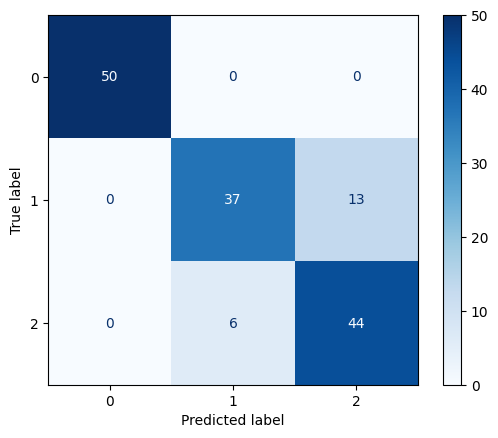

In [7]:
ConfusionMatrixDisplay.from_predictions(iris.target, y_pred, cmap = 'Blues');

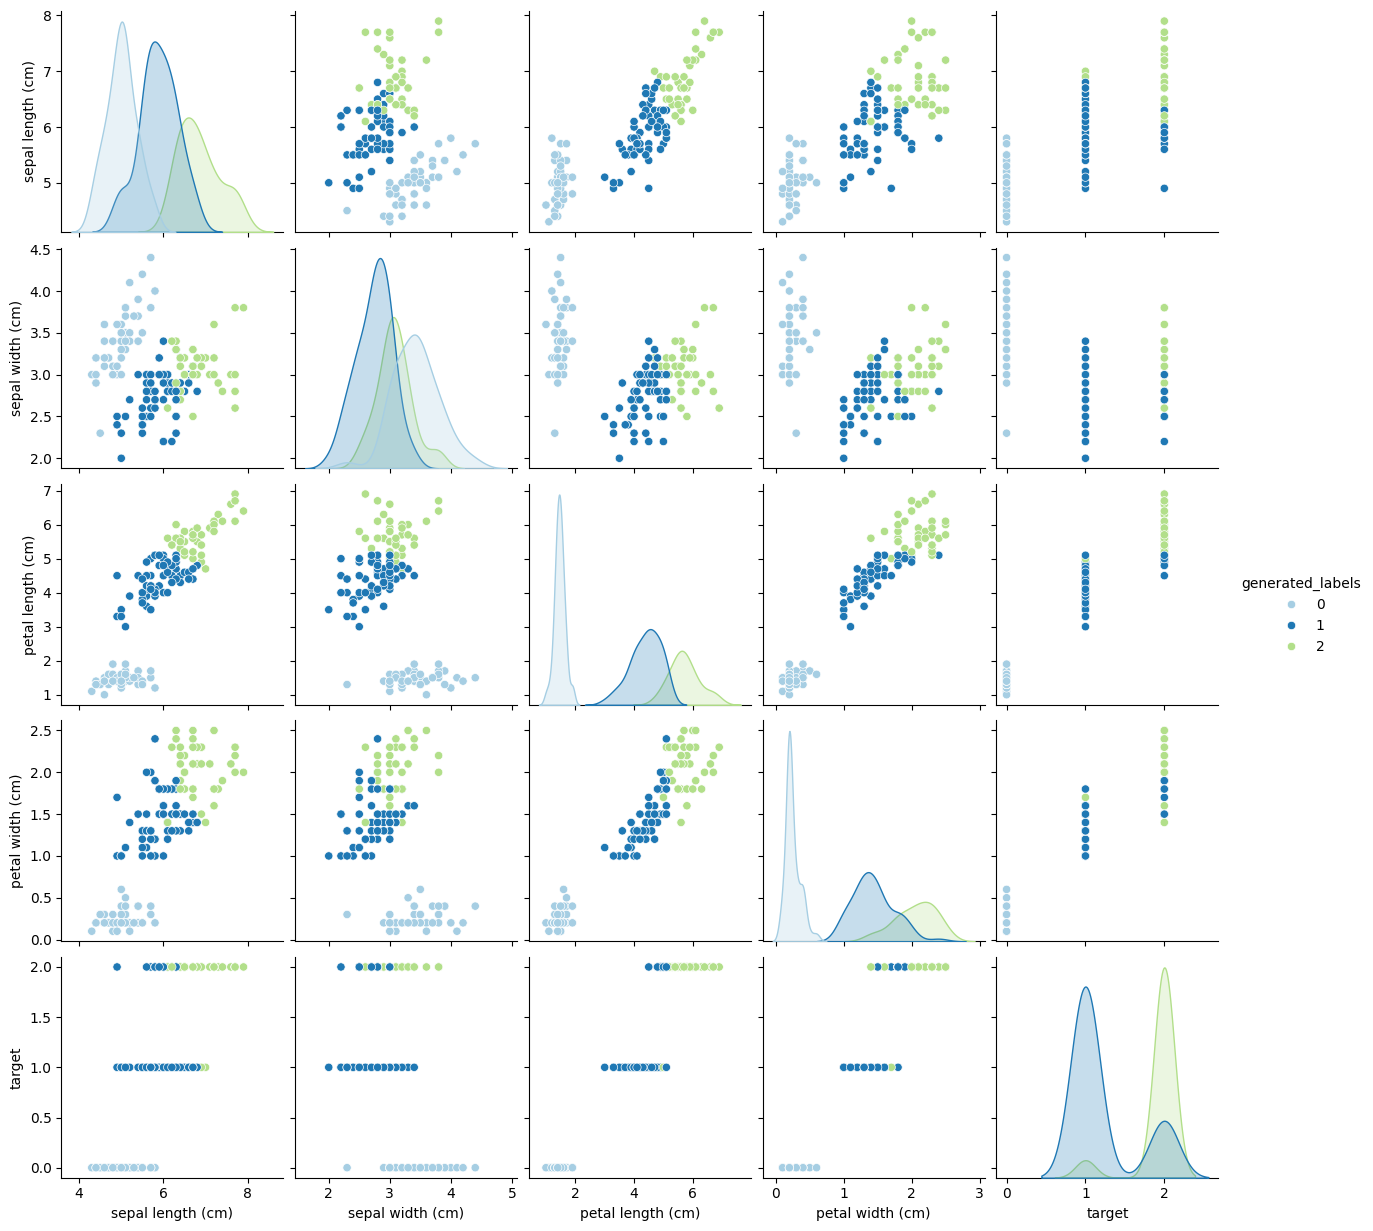

In [8]:
sns.pairplot(iris_df, hue = 'generated_labels', palette = 'Paired');